In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, pickle
import datetime as dt

# initialize a connection to the database
import sqlite3
conn = sqlite3.connect('../Spotify_Challenge/dbsql.db')

# initialize another sqlalchemy connection to the same database to be able to query data straight to pandas dataframe
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')

from sklearn.preprocessing import Imputer,StandardScaler, MinMaxScaler,scale#, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
features = [u'index',u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', 
            u'CARRIER', u'TAIL_NUM', u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN', u'ORIGIN_CITY_NAME', 
            u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', 
            u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT', u'TAXI_IN', u'ARR_DELAY', 
            u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'AIR_TIME', 
            u'FLIGHTS', u'DISTANCE', u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
            u'LATE_AIRCRAFT_DELAY',u'FL_DATE']
years = (2010,2011,2012,2013,2014,2015)

## Functions

In [314]:
# This method will be used to valuate the goodness of clusters
def se(v1,v2):
    """return the squared error between two vectors v1, v2"""
    return sum((v1-v2)**2)

def calculate_sse(df,centroids,labels):
    """Calculate the sse of instance in dataframe to the centroids"""
    labels = pd.unique(labels).tolist()
    sse = []    
    for l in labels:
        dftmp = df[df.C==c].drop('C',axis=1)
        s = sum(map(lambda x:se(x,centroids[labels.index(l)]),dftmp.values))
        sse.append(s)
    return sum(sse)

def optimize_n_k(df,n_max,k_max, gen_plot=True):
    """optimize number of components and clusters for good clustering"""
    sses = []
    ns = []
    ks = []
    for n in range(1,n_max):
        ns.append(n)
        sse = []
        for k in range(1,k_max):
            ks.append(k)
            pca = PCA(n_components=n)
            pca_data = pd.DataFrame(pca.fit_transform(df))
            km = KMeans(k,random_state=1234)
            km.fit(pca_data)
            centroids = km.cluster_centers_
            labels = km.labels_
            
            cat_data = pca_data.copy()
            cat_data['C'] = labels
            sse.append(calculate_sse(cat_data,centroids,labels))
        sses.append(sse)
    sses = np.array(sses)
    if gen_plot:
        plt.plot(sses.transpose())
        plt.legend(range(1,n_max),loc='best')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.title('n_k_optimization')
        plt.show()
    return sses, ns, ks

## Data Aggregation

In [427]:
# import raw data aggregated by year, origin and destination
tic = dt.datetime.now()
if 'agg_per_flight' in map(lambda x:x[0],conn.execute("select name from sqlite_master where type = 'table'").fetchall()):
    raw = pd.read_sql_query("SELECT * FROM agg_per_flight",disk_engine)
    if 'index' in raw.columns:
        df4.drop('index',axis=1,inplace=True)
    print "data set found and loaded"
else:
    print "querying data from db..."
    raw = pd.read_sql_query(
        "SELECT YEAR, ORIGIN, DEST, SUM(FLIGHTS) as FLIGHTS, COUNT(DISTINCT CARRIER) as CARRIER, "
        "SUM(DEP_DEL15) as DEP_DEL, SUM(ARR_DEL15) as ARR_DEL, "
        "SUM(DISTANCE) as DISTANCE, SUM(AIR_TIME) as AIR_TIME, "
        "SUM(DEP_DELAY) as DDEL1, SUM(DEP_DELAY_NEW) as DDEL2, "
        "SUM(ARR_DELAY) as ADEL1, SUM(ARR_DELAY_NEW) as ADEL2, "
        "SUM(DIVERTED) as DIVERTED, SUM(CANCELLED) as CANCELLED, "
        "SUM(SECURITY_DELAY) as SEC_DEL, SUM(CARRIER_DELAY) as CAR_DEL, "
        "SUM(NAS_DELAY) as NAS_DEL, SUM(WEATHER_DELAY) as WEA_DEL, SUM(LATE_AIRCRAFT_DELAY) as LAD_DEL "
        "FROM data "
        "GROUP BY YEAR, ORIGIN, DEST",
        disk_engine
    )
    raw[['DISTANCE','AIR_TIME']] = (raw[['DISTANCE','AIR_TIME']].T/raw['FLIGHTS']).T.values
    raw.to_sql('agg_per_flight',conn,index=False)
print dt.datetime.now()-tic

data set found and loaded
0:00:00.505629


## Data Cleaning

In [428]:
data = pd.read_sql_query("SELECT * FROM agg_per_flight",disk_engine)
numeric_features = ['FLIGHTS', 'CARRIER', 'DEP_DEL', 'ARR_DEL', 'DISTANCE', 'AIR_TIME', 
                    'DDEL1', 'DDEL2', 'ADEL1', 'ADEL2', 'DIVERTED', 'CANCELLED', 'SEC_DEL', 
                    'CAR_DEL', 'NAS_DEL', 'WEA_DEL', u'LAD_DEL']
categorical_features = ['YEAR','ORIGIN','DEST']

# impute missing values
print "imputing NA ..."
imputer = Imputer(strategy='most_frequent')
data[numeric_features] = imputer.fit_transform(data[numeric_features])

# create new features
print "creating new features ..."
data['AVE_SPEED'] = data['DISTANCE']/data['AIR_TIME']
data['REC_TIME'] = data['DDEL2'] - data['ADEL2']
data['REL_DDEL'] = data['DDEL1']/data['AIR_TIME']
data['REL_ADEL'] = data['ADEL1']/data['AIR_TIME']
data['REL_RTIME'] = data['REC_TIME']/data['AIR_TIME']
numeric_features +=['AVE_SPEED','REC_TIME','REL_DDEL','REL_ADEL','REL_RTIME']

# Normalize with respect to the number of flights
print "normalizing to the total number of flights ..."
features_norm = ['DEP_DEL', 'ARR_DEL', 'DDEL1', 'DDEL2', 'ADEL1', 'ADEL2', 'DIVERTED', 'CANCELLED', 'SEC_DEL', 
                 'CAR_DEL', 'NAS_DEL', 'WEA_DEL', u'LAD_DEL','REC_TIME','REL_DDEL','REL_ADEL','REL_RTIME']
data[features_norm] = (data[features_norm].T/data['FLIGHTS']).T.values

imputing NA ...
creating new features ...
normalizing to the total number of flights ...


## Data Exploration

#### 1. Correlations test

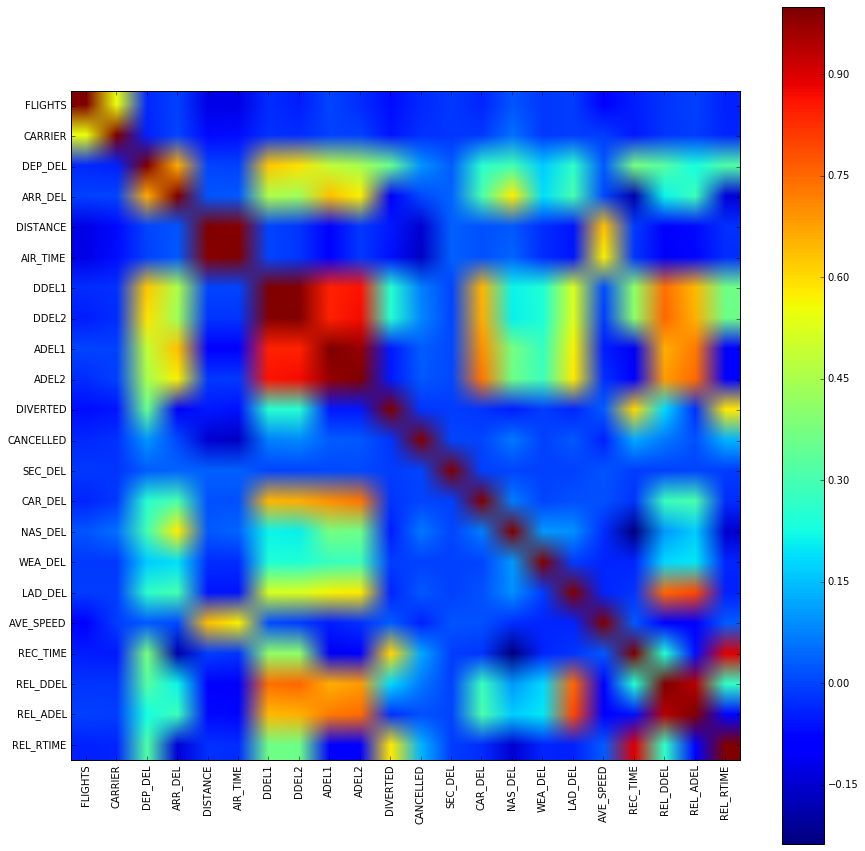

In [429]:
# have a look at the correlations between features
# Note: run the correlation test before rescaling data
corr_mat = data[numeric_features].corr()
fig,ax = plt.subplots(1,1,figsize = [15,15])
plt.imshow(corr_mat)
plt.xticks(range(corr_mat.shape[0]),corr_mat.columns,rotation = 'vertical')
plt.yticks(range(corr_mat.shape[0]),corr_mat.columns)
plt.colorbar()
plt.savefig('corr_flights2.eps',format='eps')
plt.show()

#fig,ax = plt.subplots(1,1,figsize = [30,15])
#pd.tools.plotting.scatter_matrix(data[numeric_features], alpha=0.1,ax=ax)
#plt.tight_layout()

In [430]:
low_corr_features = ['FLIGHTS','CARRIER','DEP_DEL','DISTANCE','DDEL1','DIVERTED','CANCELLED','SEC_DEL',
                     'CAR_DEL','NAS_DEL','WEA_DEL','LAD_DEL','AVE_SPEED','REC_TIME','REL_DDEL']

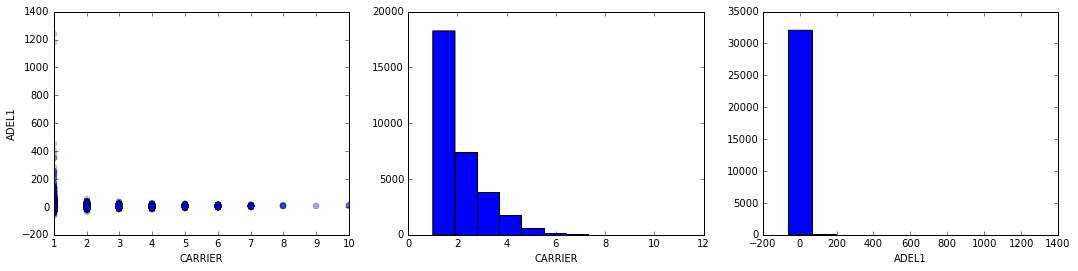

In [431]:
fig,ax = plt.subplots(1,3,figsize=[18,4])
yl = 'ADEL1' #<- change variable to look at the correlation plot closely
xl = 'CARRIER' #<- change variable to look at the correlation plot closely
#for year in years:
ax[0].plot(data[xl],data[yl],'o',alpha = 0.2)
ax[1].hist(data[xl])
ax[2].hist(data[yl])
ax[0].set_xlabel(xl)
ax[0].set_ylabel(yl)
ax[1].set_xlabel(xl)
ax[2].set_xlabel(yl)
#ax[0].set_ylim([0,50])
plt.show()

#### 2. Variance analysis

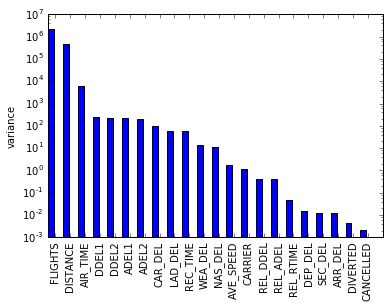

In [432]:
var_mat = pd.DataFrame(data[numeric_features].var(),columns=['variance'])
var_mat = var_mat.sort_values('variance',ascending=False)
plt.bar(np.arange(var_mat.shape[0])*2,var_mat.values)
#plt.xticks(range(0,len(numeric_features)),label=numeric_features,rotation='vertical')
plt.xticks(np.arange(len(numeric_features))*2+1,var_mat.index,rotation='vertical')
plt.yscale('log')
plt.ylabel('variance')
plt.show()

In [433]:
low_corr_features = ['FLIGHTS','CARRIER','DEP_DEL','DISTANCE','DDEL1','DIVERTED','CANCELLED','SEC_DEL',
                     'CAR_DEL','NAS_DEL','WEA_DEL','LAD_DEL','AVE_SPEED','REC_TIME','REL_DDEL']
# get features sorted by variance
high_var_features = var_mat.index.tolist()
print(high_var_features)

[u'FLIGHTS', u'DISTANCE', u'AIR_TIME', u'DDEL1', u'DDEL2', u'ADEL1', u'ADEL2', u'CAR_DEL', u'LAD_DEL', 'REC_TIME', u'WEA_DEL', u'NAS_DEL', 'AVE_SPEED', u'CARRIER', 'REL_DDEL', 'REL_ADEL', 'REL_RTIME', u'DEP_DEL', u'SEC_DEL', u'ARR_DEL', u'DIVERTED', u'CANCELLED']


In order to optimize clusters, we shall chose the most import features. These are features which are not highly correlated between each other and which have high degree of variance

## Search for clusters

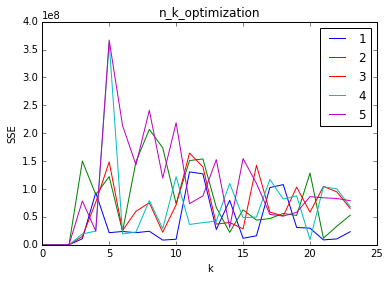

0:05:41.371130


In [434]:
# Let's now optimize the number of clusters and number of principle components
sse = []
tic = dt.datetime.now()
sse,ns,ks = optimize_n_k(resc_data[numeric_features],n_max=6,k_max=25)  
print dt.datetime.now()-tic


We can choose (n=4, k=20) or (n=3,k=15,20) or (n=2, k=15,21)

In [455]:
# rescale features
std_scaler = StandardScaler()
resc_data = pd.DataFrame(std_scaler.fit_transform(data[numeric_features]), columns = numeric_features)

# reduce dimension using pca
n_components = 2
K = 21
pca = PCA(n_components=n_components)
pca_data = pd.DataFrame(pca.fit_transform(resc_data[numeric_features]),columns=range(n_components))

# generate clusters using rescaled and dimension-reduced data
kmeans = KMeans(K,random_state=1234)
kmeans.fit(pca_data)

# extract centroid and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

cat_data = pca_data.copy()
cat_data['C'] = labels

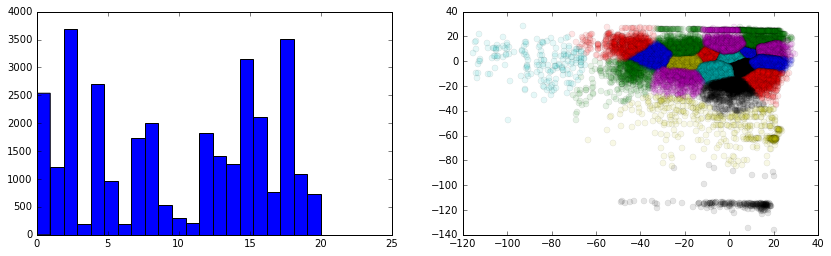

In [456]:
fig,ax = plt.subplots(1,2,figsize=[14,4])
ax[0].hist(labels,bins=K)
for c in pd.unique(cat_data.C):
    ax[1].plot(cat_data[cat_data.C==c][0],cat_data[cat_data.C==c][1],'o',alpha = 0.1)
plt.show()

In [458]:
#if not 'flights_clusters' in map(lambda x:x[0],conn.execute('select name from sqlite_master where type ="table"').fetchall()):
data['C'] = labels
#data.to_sql('flights_clusters',conn,index=False,if_exists='replace')
print "table pushed to db"

table pushed to db


#### Hypothesis:
1. The flight duration/delay and direction (east to west, south to north or vce-verse) might be correlated
2. [- Checked] The delay and the number of carriers operating between two points might be correlated

#### Features engineering:
1. [-Done] Average speed 

#### Not to forget:
1. [- Done] rescale numeric features between 0 and 1
2. add column of origin/dest's clusters (use airport clusters table)
3. drop outliers (data out of $\mu\pm3\sigma$) or replace them with the most frequent values